In [1]:
from standardInclude import *

Welcome to JupyROOT 6.20/04
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


### Start by defining some helper functions and constants

In [2]:
#only one calo at a time for simplicity
caloToPlot = 19
allFitResults = []

In [3]:
def randomizeTimes( x, p=[None] ):
    inputtime = x[0]
    time = inputtime
    
    w0 = 2.6094;
    A = 2.80;
    tauA = 56.6;
    B = 6.18;
    tauB = 6.32;
    
    wCBO =  (w0 - (A/(tauA)) * r.TMath.Exp(-time/(1000.0*tauA)) - (B/(tauB)) * r.TMath.Exp(-time/(tauB*1000.0)) ); #MHz
    wa =  r.TMath.TwoPi() * 0.2291; #MHZ
    wc =  r.TMath.TwoPi() / 0.14919; #MHz

    factor = 1.0;
    wY = factor * (wCBO) * r.TMath.Sqrt( (2 * wc / (factor * wCBO)) -1.0 ) ;
    wVW = wc - (2.0 * wY);

    TCBO = r.TMath.TwoPi() / wCBO;
    Ta = r.TMath.TwoPi() / wa;
    TVW = r.TMath.TwoPi() / wVW;
    TY = r.TMath.TwoPi() / wY;
    T_diff= r.TMath.TwoPi()/(wCBO-wa);
    
    #time += (rng->Uniform()-0.5)*(Ta*1000.0);// w_a 4365
    timestorandomize = [
                        Ta, 
                        TCBO, 
                        TVW, 
                        TY, 
                        T_diff,
                       ]
    
    for periodi in timestorandomize:
        #time += (np.random.random() - 0.5)*(periodi)
        time += -1*np.abs((np.random.random() - 0.5))*(periodi)
    #print(inputtime, time, TCBO, Ta)
    
    #print(time, time/1000.)
    return time

---

# Matched Tracks

### Lets begin with the calo-matched tracks for the endgame, using default parameters

In [43]:
t = r.TChain("tree")
#t.Add("./data/sam_trees_endgame/trackAndTrackCaloTrees_17159.root")
#t.Print()
t.Add("./data/sam_trees_endgame/*root")

242

---

# Extrapolate out the position without the radial field

In [32]:
%%time

#extrapolate out position ignoring radial field
vec = []

for i, e in enumerate(t):
    if(i > 1000):
        break
        
    initialMomentum = -1*e.decayVertexMomY  #From James/Joe: Backwards extrapolation flips momentum
    initialPosition = e.decayVertexPosY
    
    finalPosition = e.caloVertexPosY
    
    deltaT = e.caloVertexTime -  e.decayTime
    muonMass = 105.66# MeV
    electronMass = 0.511 #MeV
    speedOfLight = 299.8 #mm/ns
    gamma = 29.3 #just assume magic momentum
    
    #deltaY = deltaT * (initialMomentum / muonMass)*21.1 #mm
    deltaY = (deltaT * initialMomentum)/(gamma * electronMass)
    deltaY_tracker = finalPosition - initialPosition
    
    deltaY_tracker = e.decayVertexPosY - (e.caloVertexTime -  e.decayTime) * 299.79 * e.decayVertexMomY / e.decayVertexMom
    
    ding = [initialMomentum, initialPosition, deltaT, finalPosition, deltaY_tracker, deltaY, e.clusterCaloNum[0],
           e.caloVertexTime]
    vec.append(ding)
    #print(ding)
    
names = ['initialMomentum', 'initialPosition', 'deltaT', 'finalPosition', 'deltaY_tracker', 'deltaY', 'calo',
        'caloTime'] 
df = pandas.DataFrame(vec, columns=names)
df.head()

CPU times: user 3.02 s, sys: 80.5 ms, total: 3.1 s
Wall time: 3.08 s


,initialMomentum,initialPosition,deltaT,finalPosition,deltaY_tracker,deltaY,calo,caloTime
0,-17.280901,-2.860963,5.250000,-28.309460,-27.279094,-6.059505,13,105775.656250
1,7.453754,19.710024,8.398438,29.355957,28.733404,4.181047,19,24729.462891
2,-9.651390,-11.038027,5.718750,-23.865498,-22.752741,-3.686400,19,81527.421875
3,-4.027790,0.983300,8.398438,-4.186967,-4.083316,-2.259315,19,102518.335938
4,-3.571614,8.270003,9.269531,4.037958,3.347009,-2.211229,13,26903.656250


In [33]:
muonMass = 105.66# MeV
electronMass = 0.511 #MeV
speedOfLight = 299.8 #mm/ns
gamma = 29.3 #just assume magic momentum
print(gamma * electronMass)

14.9723


In [34]:
df = df.loc[df['calo'] == caloToPlot].sort_values('deltaY_tracker')
df.head()

,initialMomentum,initialPosition,deltaT,finalPosition,deltaY_tracker,deltaY,calo,caloTime
95077,-23.411207,13.453555,6.195312,-109.348297,-76.806569,-9.687205,19,84729.695312
83541,-26.483713,21.354040,5.714844,-96.466515,-71.624996,-10.108686,19,10966.455078
18670,-21.503843,0.273326,6.599609,-104.200745,-70.391978,-9.478635,19,22780.708984
83857,-17.764513,-2.100525,6.382812,-106.423607,-69.222781,-7.573155,19,14177.922852
56797,-27.998440,16.931862,5.982422,-94.144791,-68.370476,-11.187224,19,10225.638672


In [37]:
df.describe()

,initialMomentum,initialPosition,deltaT,finalPosition,deltaY_tracker,deltaY,calo,caloTime
count,46894.000000,46894.000000,46894.000000,46894.000000,46894.000000,46894.000000,46894.0,46894.000000
mean,-0.280694,0.506636,7.944050,0.127386,0.113401,-0.173887,19.0,65043.111482
std,19.652188,12.704168,2.394682,26.512217,24.338413,10.471835,0.0,63064.721818
min,-67.776299,-69.176460,3.107422,-109.348297,-76.806569,-46.430182,19.0,2170.510498
25%,-14.976199,-8.336965,6.156250,-21.336330,-19.965721,-7.515208,19.0,20358.680664
50%,-0.335385,0.416124,7.390625,0.173461,0.165538,-0.177744,19.0,45164.572266
75%,14.525817,9.269949,9.382812,21.684628,20.195016,7.213245,19.0,88953.712891
max,79.945496,73.537148,17.234375,119.334587,83.999070,45.052538,19.0,646087.750000


In [35]:
%%time

func =r.TF1("func","pol1",-100,100,2)
func.SetParameters(0,-1)
fit = fitVector(df['deltaY_tracker'], df['deltaY'], func )

#fit.draw(do_pulls=False, fmt=".")
#plt.show()

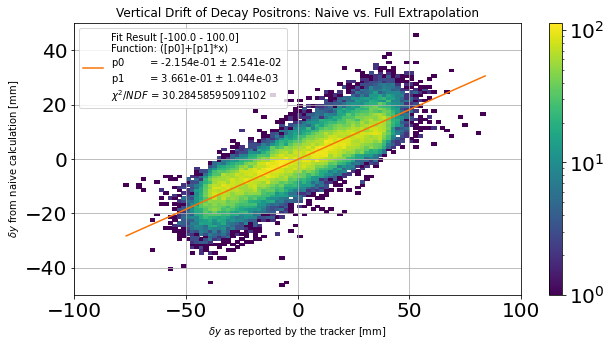

In [36]:
fig,ax = plt.subplots(figsize=(10,5))
plt.hist2d(df['deltaY_tracker'], df['deltaY'],bins=(100,100), range=[[-100,100],[-50,50]],
          norm = matplotlib.colors.LogNorm()
          )
fit.drawFitResult(ax)
#fit.drawConfidenceIntervals(ax)
plt.grid()
plt.colorbar()
plt.xlabel(r"$\delta y$ as reported by the tracker [mm]")
#plt.ylabel(r"$\delta y$ from naive calculation:"+"\n"+r" $\delta y = (\delta t * p_{0-y}) / (\gamma * m_{e} )$ [mm]")
plt.ylabel(r"$\delta y$ from naive calculation [mm]")
plt.title("Vertical Drift of Decay Positrons: Naive vs. Full Extrapolation")
plt.legend()
plt.show()

In [144]:
h = r.TH2D("h",
          "EndGame: Vertical Drift of Decay Positrons: Naive vs. Full Extrapolation; Tracker #deltay [mm]; Naive Extrapolation: #deltat*c*p_{y}/p_{tot} [mm]",
          100,-100,100,
          100,-100,100)
t.Draw((" (caloVertexTime -  decayTime) * 299.79 * decayVertexMomY /"+
        " decayVertexMom"+
        ":(decayVertexPosY - caloVertexPosY)>>h"),"","goff")

21575417

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


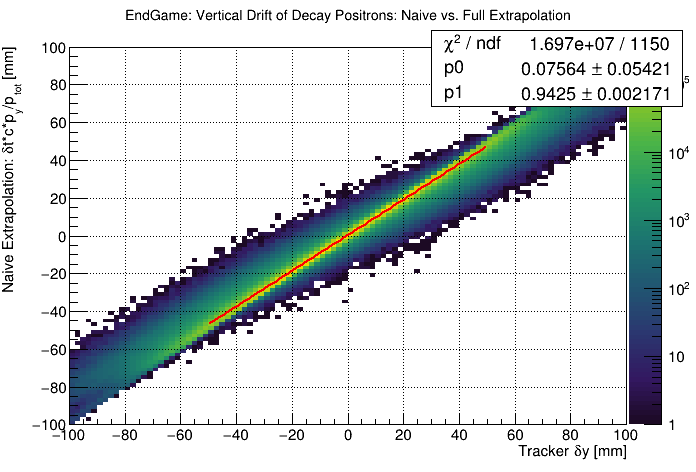

In [145]:
c = r.TCanvas()
h.Draw("colz")
func = r.TF1("func","pol1",-50,50)
h.Fit("func","REMBQ")
c.SetLogz()
c.SetGrid()
c.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


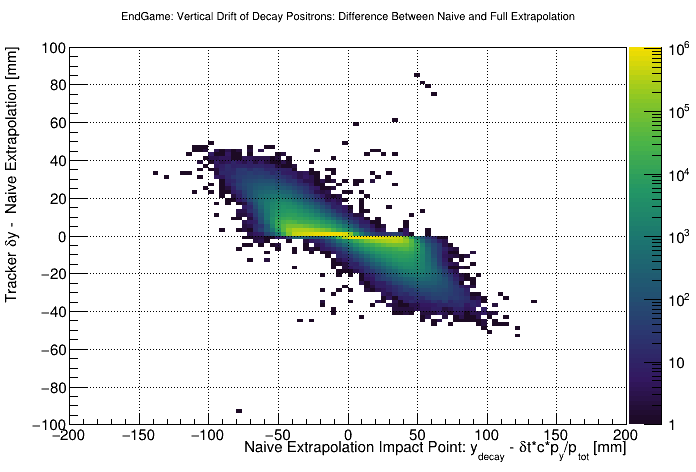

In [221]:
h = r.TH2D("h",
          "EndGame: Vertical Drift of Decay Positrons: Difference Between Naive and Full Extrapolation; Naive Extrapolation Impact Point: y_{decay} - #deltat*c*p_{y}/p_{tot} [mm]; Tracker #deltay -  Naive Extrapolation [mm]",
            100, -200,  200,
            100,-100,100
          )
t.Draw(" ( (decayVertexPosY - caloVertexPosY) - (caloVertexTime -  decayTime) * 299.79 * decayVertexMomY / decayVertexMom) : (decayVertexPosY - (caloVertexTime -  decayTime) * 299.79 * decayVertexMomY / decayVertexMom)>>h","","colz")
c.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


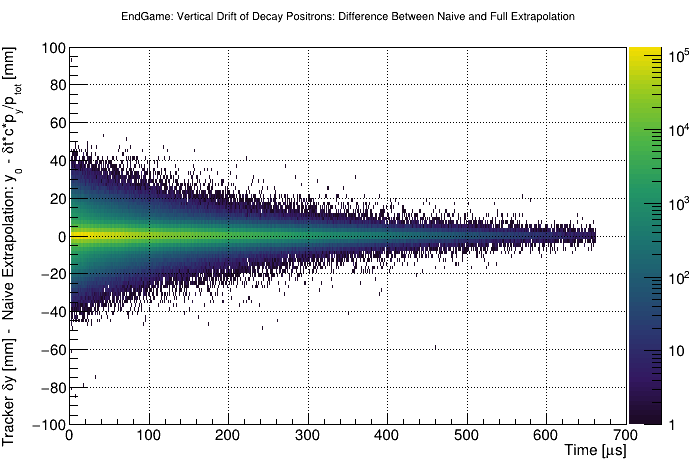

In [222]:
h = r.TH2D("h",
          "EndGame: Vertical Drift of Decay Positrons: Difference Between Naive and Full Extrapolation; Time [#mus]; Tracker #deltay [mm] -  Naive Extrapolation: y_{0} - #deltat*c*p_{y}/p_{tot} [mm]",
            700, 0,  700,
            100,-100,100
          )
t.Draw(" ( (caloVertexTime -  decayTime) * 299.79 * decayVertexMomY / decayVertexMom) - (decayVertexPosY - caloVertexPosY):clusterTime/1000.>>h","","colz")
c.Draw()

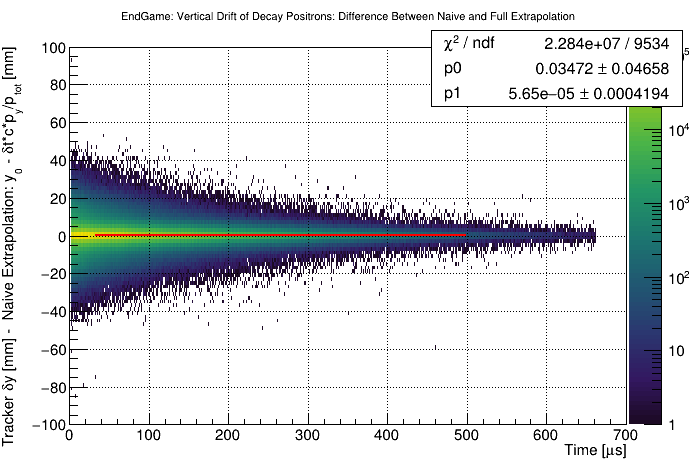

In [223]:
c = r.TCanvas()
h.Draw("colz")
func = r.TF1("func","pol1",30,500)
h.Fit("func","REMBQ")
#h.GetXaxis().SetRangeUser(0,30)
c.SetLogz()
c.SetGrid()
c.Draw()

In [224]:
def fitfunc(choice, fitrange, params=None):
    tlow, thigh = fitrange
    if(choice is 0):
        func = r.TF1("func","[0] + [1] - [1]/(TMath::Exp([2]*x)) + [3]*(x)",tlow,thigh)
        func.SetParNames("C", "A", "1/#tau", "m")
        if(params is None):
            paramVec = [1,10,1,-0.0001,10]
        else:
            paramVec = params
        for i,xi in enumerate(paramVec):
            func.SetParameter(i,xi)
        return (func,paramVec)
    elif(choice is 1):
        func = r.TF1("func","pol1",tlow,thigh)
        func.SetParNames("C", "m")
        if(params is None):
            params = [1,-0.00001]
        for i,xi in enumerate(params):
            func.SetParameter(i,xi)
        return (func, params)
    else:
        print("Invalid choice")
        return -1

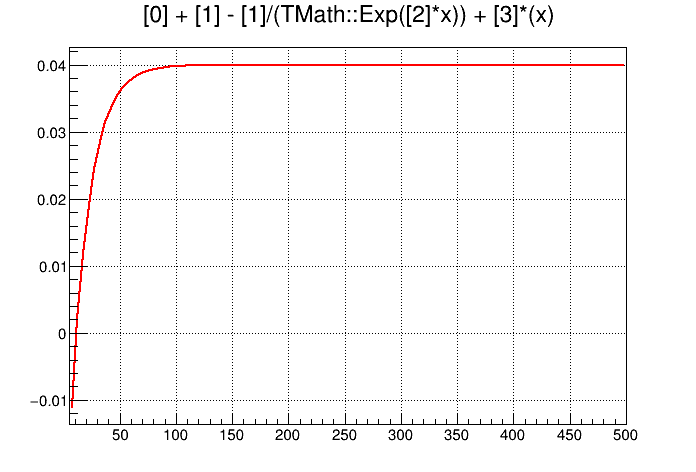

In [225]:
func = fitfunc(0,[5,500],[-0.04,0.08,0.06,0])[0]
func.Draw()
c.Draw()

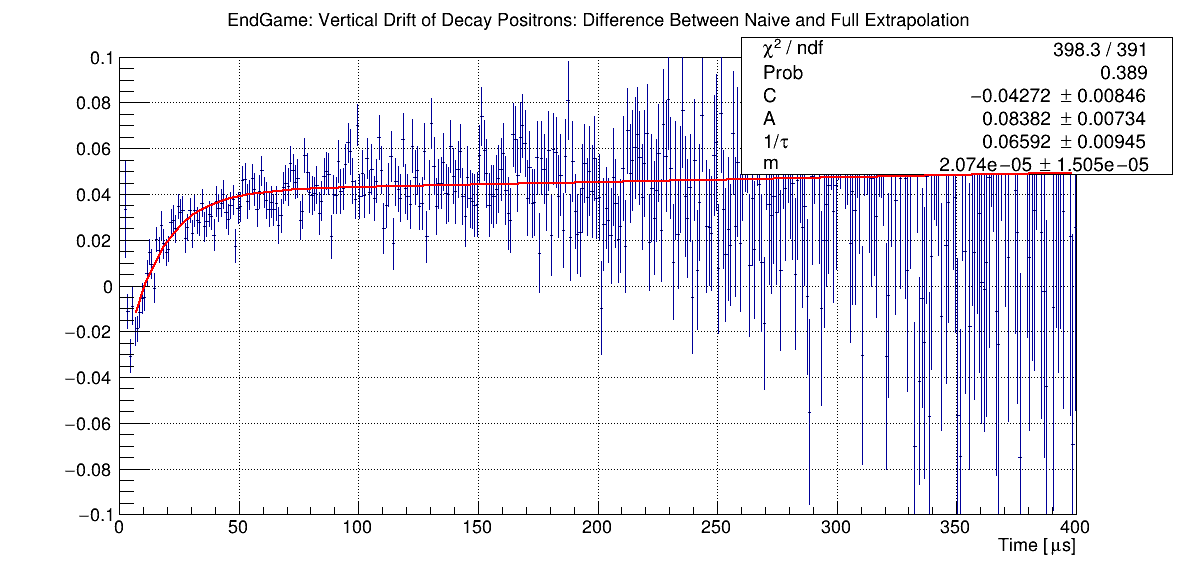

In [226]:
c = r.TCanvas("c","c",1200,600)
h2 = h.ProfileX()
r.gStyle.SetOptFit(11111)
h2.Draw("")
func = fitfunc(0,[5,500],[-0.04,0.08,0.06,0])[0]
for i in range(2):
    h2.Fit(func,"REMBQ")
func.Draw("same")
h2.GetYaxis().SetRangeUser(-0.1,0.1)
h2.GetXaxis().SetRangeUser(0,400)
c.SetLogz()
c.SetGrid()
c.Draw()

---

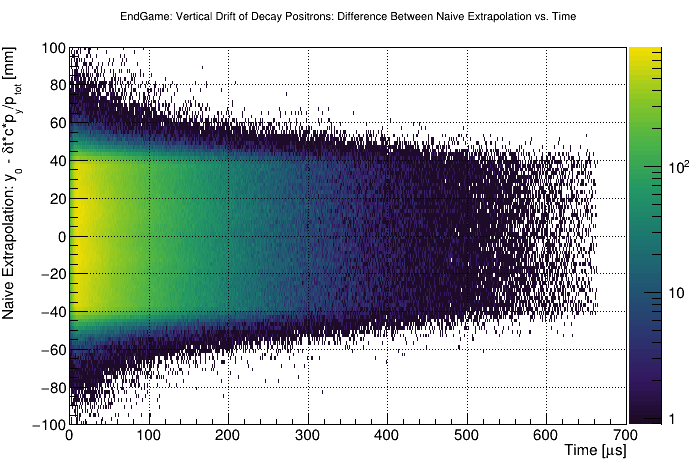

In [170]:
r.globalSeed = 1234
r.gInterpreter.ProcessLine('.L testfunc.C')
r.initializeRNG(1234)

h = r.TH2D("h",
          "EndGame: Vertical Drift of Decay Positrons: Difference Between Naive Extrapolation vs. Time; Time [#mus]; Naive Extrapolation: y_{0} - #deltat*c*p_{y}/p_{tot} [mm]",
            7000, 0,  700,
            100,-100,100
          )
t.Draw(" (decayVertexPosY - (caloVertexTime -  decayTime) * 299.79 * decayVertexMomY / decayVertexMom):testfunc(clusterTime)/1000.>>h","","colz")
c.Draw()

In [171]:
widthDict = getWidths(h)

In [196]:
tlow = 5
thigh = 300
func,paramVec = fitfunc(0, [tlow,thigh], [27, -1, 0.05,0.0001]) 

fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'],nFit=2)

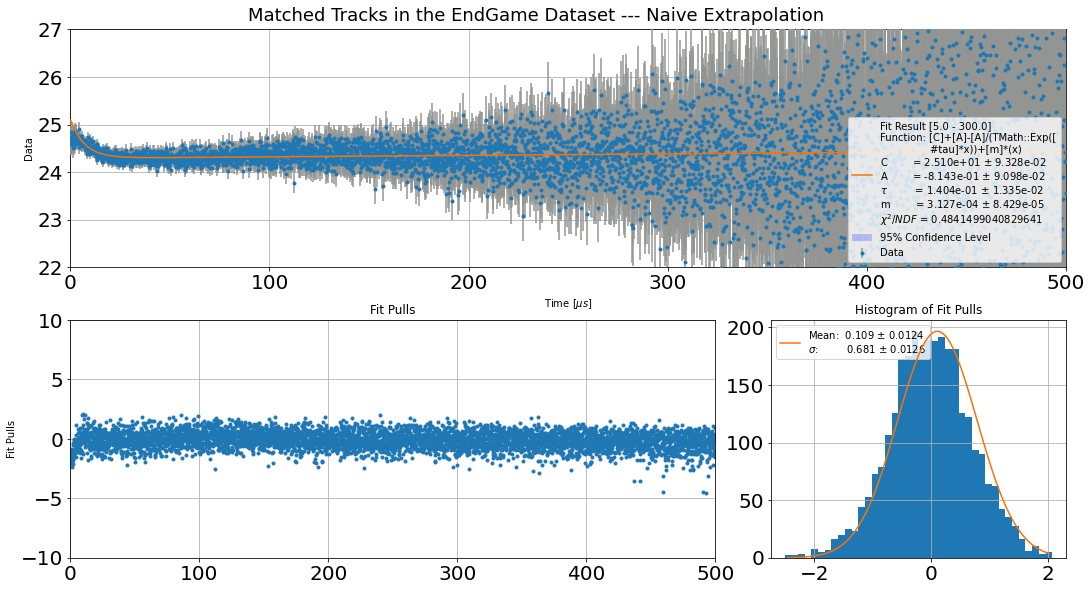

In [198]:
#fitresult.f.SetParameters(27,-17,0.00053,0.061)
dataset='EndGame'
fig,ax = fitresult.draw("Matched Tracks in the "+dataset+" Dataset --- Naive Extrapolation", 
                        yrange=[None, [-10,10]], fmti=".")
ax[0].set_ylim(22,27)
for i in range(2):
    ax[i].set_xlim(0,500)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

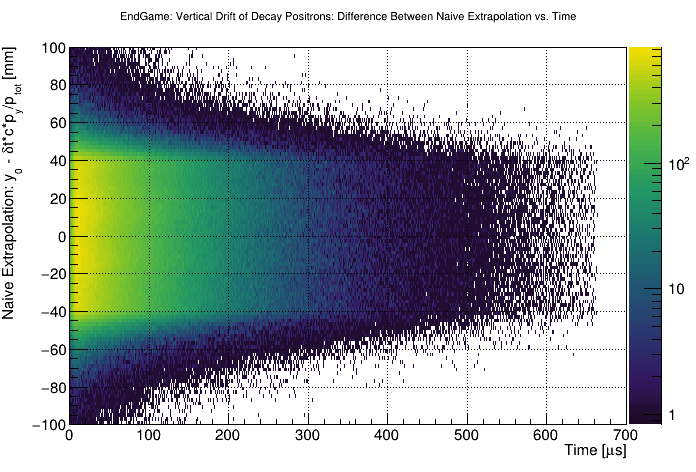

In [163]:
h2 = r.TH2D("h2",
          "EndGame: Vertical Drift of Decay Positrons: Difference Between Naive Extrapolation vs. Time; Time [#mus]; Naive Extrapolation: y_{0} - #deltat*c*p_{y}/p_{tot} [mm]",
            7000, 0,  700,
            100,-100,100
          )
t.Draw(" caloVertexPosY:testfunc(clusterTime)/1000.>>h2","","colz")
c.Draw()

In [164]:
widthDict2 = getWidths(h2)

In [201]:
tlow = 5
thigh = 300
func,paramVec = fitfunc(0, [tlow,thigh], [27, -1, 0.05,0.0001]) 

fitresult2 = fitVector(widthDict2['times'], widthDict2['widths'], func, None, widthDict2['widthErrs'],nFit=2)

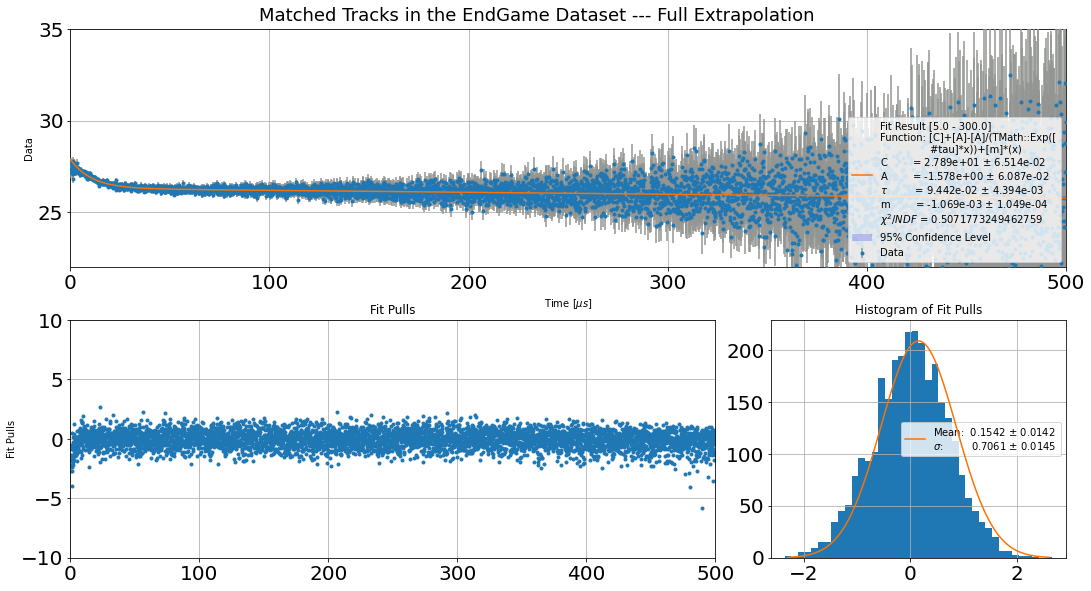

In [202]:
#fitresult.f.SetParameters(15,-170,0.00053,0.061)
dataset='EndGame'
fig,ax = fitresult2.draw("Matched Tracks in the "+dataset+" Dataset --- Full Extrapolation", 
                        yrange=[None, [-10,10]], fmti=".")
ax[0].set_ylim(22,35)
for i in range(2):
    ax[i].set_xlim(0,500)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

---

# Means

In [203]:
tlow = 5
thigh = 300
func,paramVec = fitfunc(0, [tlow,thigh], [27, -1, 0.05,0.0001]) 

fitresult = fitVector(widthDict['times'], widthDict['means'], func, None, widthDict['meanErrs'],nFit=2)

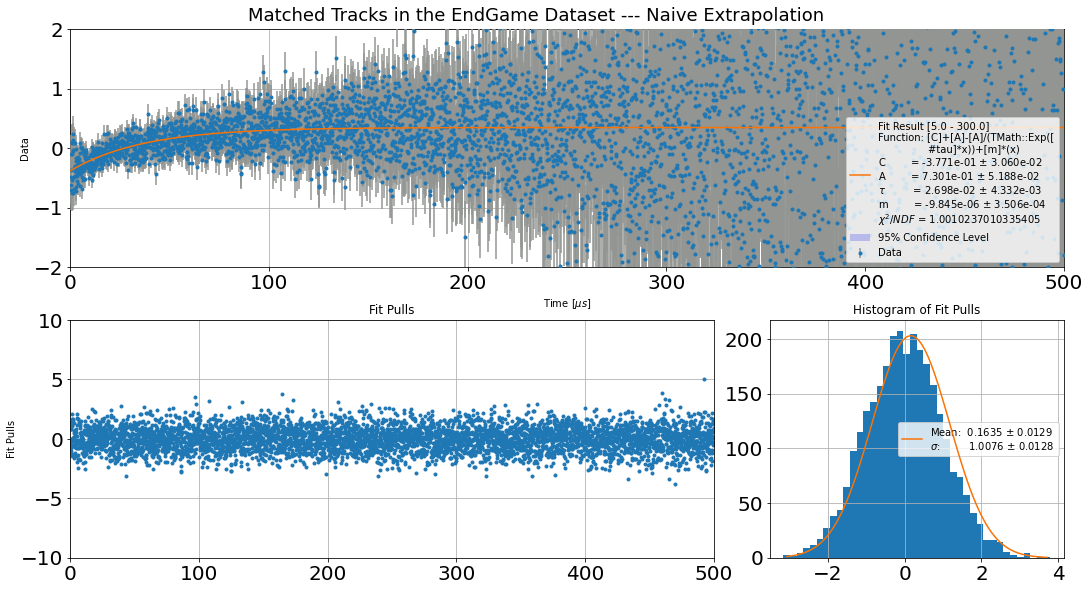

In [205]:
#fitresult.f.SetParameters(27,-17,0.00053,0.061)
dataset='EndGame'
fig,ax = fitresult.draw("Matched Tracks in the "+dataset+" Dataset --- Naive Extrapolation", 
                        yrange=[None, [-10,10]], fmti=".")
ax[0].set_ylim(-2,2)
for i in range(2):
    ax[i].set_xlim(0,500)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

In [206]:
tlow = 5
thigh = 300
func,paramVec = fitfunc(0, [tlow,thigh], [27, -1, 0.05,0.0001]) 

fitresult2 = fitVector(widthDict2['times'], widthDict2['means'], func, None, widthDict2['meanErrs'],nFit=2)

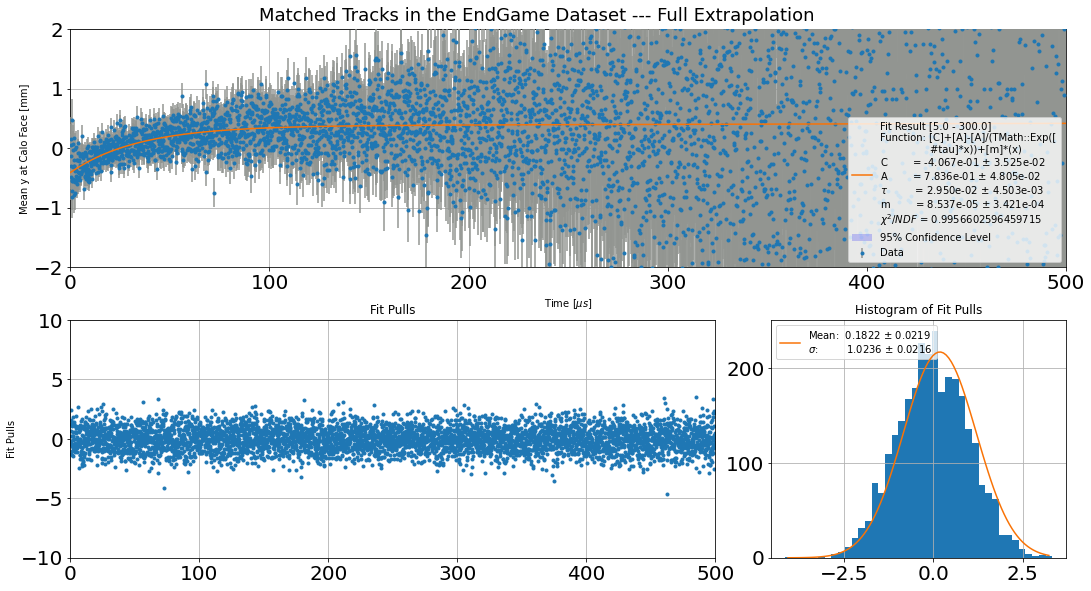

In [210]:
#fitresult.f.SetParameters(15,-170,0.00053,0.061)
dataset='EndGame'
fig,ax = fitresult2.draw("Matched Tracks in the "+dataset+" Dataset --- Full Extrapolation", 
                        yrange=[None, [-10,10]], fmti=".")
ax[0].set_ylim(-2,2)
for i in range(2):
    ax[i].set_xlim(0,500)
ax[0].set_xlabel(r"Time [$\mu s$]")
ax[0].set_ylabel(r"Mean y at Calo Face [mm]")


plt.show()

In [75]:
func

(<ROOT.TF1 object ("func") at 0x55798fbe6e30>, [1, -1e-05])

In [12]:
func =r.TF1("func","pol1",20,400,2)
func.SetParameters(0,-1)
fit = fitVector(df['caloTime']/1000., 
                df['deltaY']- df['deltaY_tracker'], 
                func )

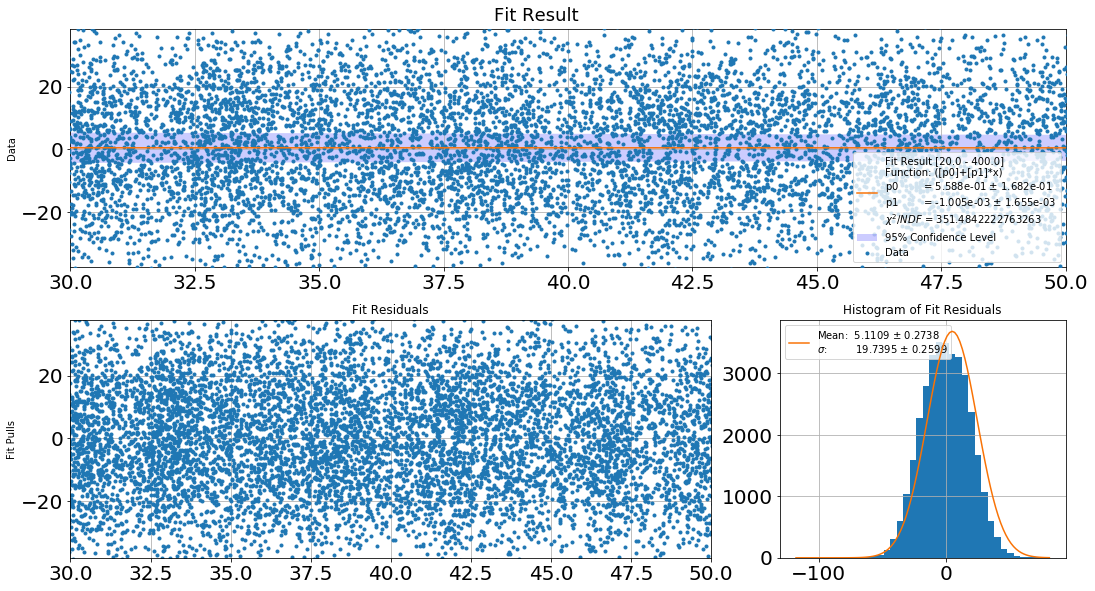

In [18]:
fig, ax = fit.draw(do_pulls=False, fmt=".")
for i in range(0,2):
    ax[i].set_xlim(30,50)
plt.show()

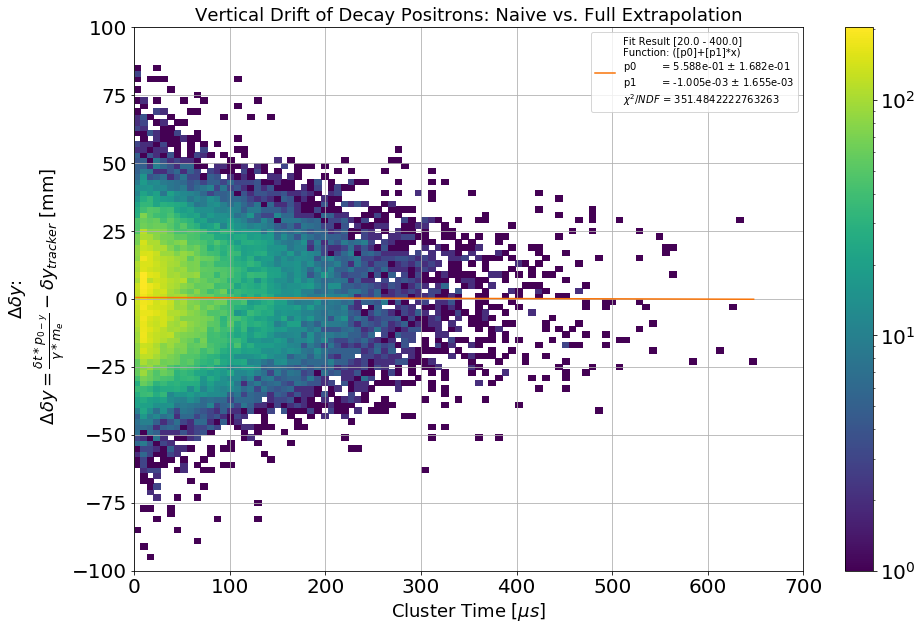

In [13]:
fig,ax = plt.subplots(figsize=(15,10))

plt.hist2d(df['caloTime']/1000.,
            df['deltaY']- df['deltaY_tracker'],  
            #c=df['initialMomentum']
           norm = matplotlib.colors.LogNorm(),
           bins=(100,100), range=[[0,700],[-100,100]]
           )
plt.xlabel(r"Cluster Time [$\mu s$]", fontsize=18)
plt.ylabel(r"$\Delta \delta y$:"+"\n"+r" $\Delta \delta y = \frac{ \delta t * p_{0-y} }{ \gamma * m_{e} } - \delta y_{tracker}$ [mm]", fontsize=18)
plt.title("Vertical Drift of Decay Positrons: Naive vs. Full Extrapolation", fontsize=18)
fit.drawFitResult(ax)
plt.legend()
plt.colorbar()
plt.grid()
plt.show()

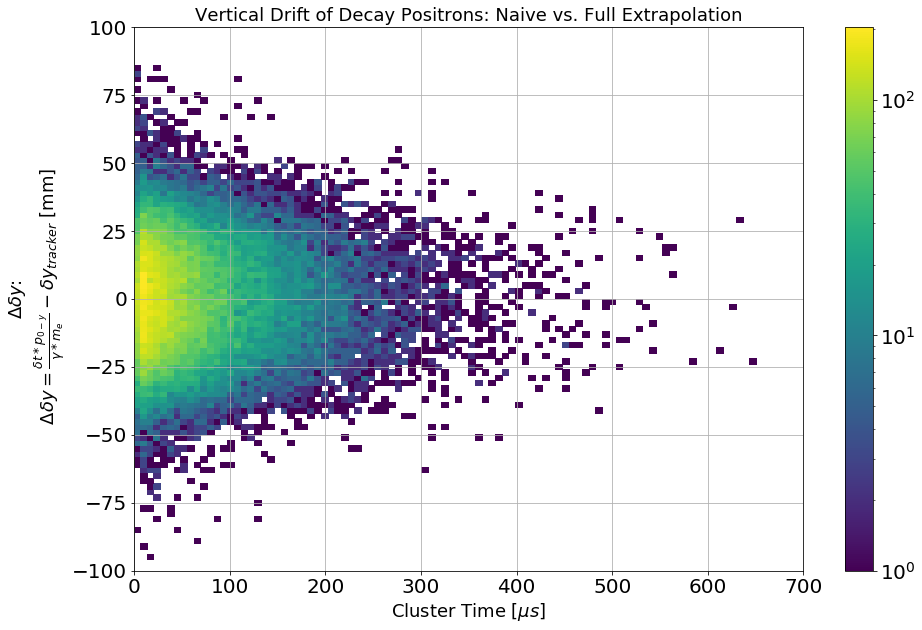

In [167]:
fig,ax = plt.subplots(figsize=(15,10))

plt.hist2d(df['caloTime']/1000.,
            df['deltaY']- df['deltaY_tracker'],  
            #c=df['initialMomentum']
           norm = matplotlib.colors.LogNorm(),
           bins=(100,100), range=[[0,700],[-100,100]]
           )
plt.xlabel(r"Cluster Time [$\mu s$]", fontsize=18)
plt.ylabel(r"$\Delta \delta y$:"+"\n"+r" $\Delta \delta y = \frac{ \delta t * p_{0-y} }{ \gamma * m_{e} } - \delta y_{tracker}$ [mm]", fontsize=18)
plt.title("Vertical Drift of Decay Positrons: Naive vs. Full Extrapolation", fontsize=18)
fit.drawFitResult(ax)
plt.legend()
plt.colorbar()
plt.grid()
plt.show()

---

# Misc. quick plots

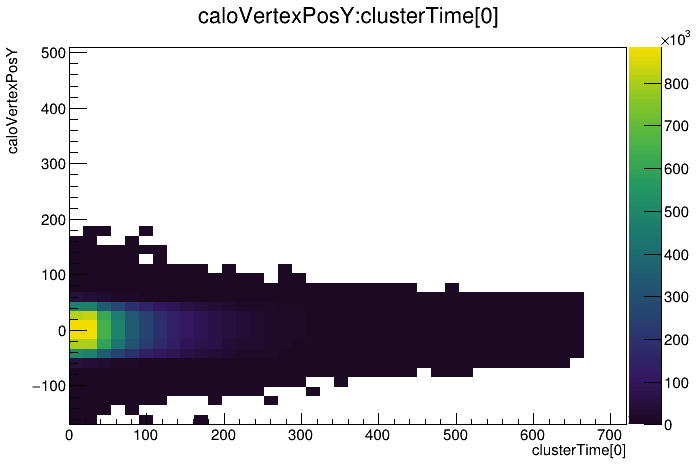

In [99]:
c = r.TCanvas()
t.Draw("caloVertexPosY:clusterTime[0]","","colz")
c.Draw()

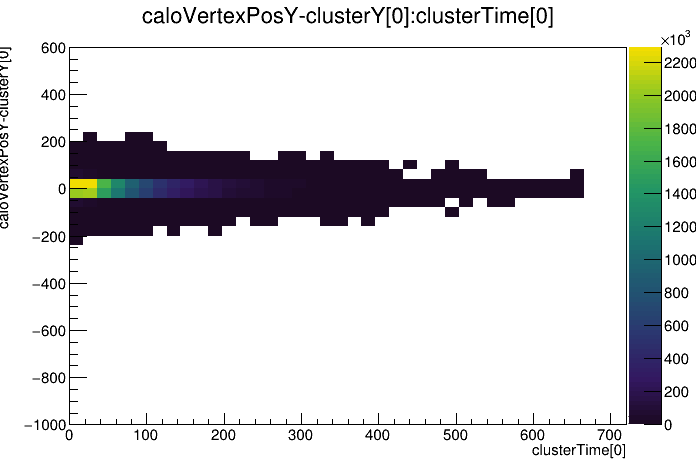

In [100]:
c = r.TCanvas()
t.Draw("caloVertexPosY-clusterY[0]:clusterTime[0]","","colz")
c.Draw()

In [131]:
h_yDiff = r.TH2I("h_yDiff",
                 "Difference in Cluster y-Position and Tracker Extrapolated y-Position vs. Time; Cluster Time [#mus]; #delta y [mm]",
                 4700*4,0,700,
                 1000,-200,200
                )
t.Draw("caloVertexPosY-clusterY[0]:clusterTime[0]/1000.>>h_yDiff","","goff")

21575417

Warning in <TFile::Append>: Replacing existing TH1: h_yDiff (Potential memory leak).


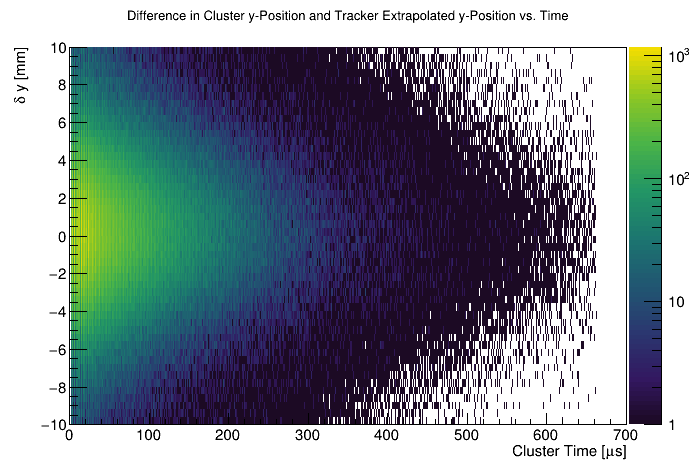

In [132]:
c = r.TCanvas()
h_yDiff.GetYaxis().SetRangeUser(-10,10)
h_yDiff.Draw("colz")
c.SetLogz()
c.Draw()


****************************************
Minimizer is Linear
Chi2                      =       385792
NDf                       =        15358
p0                        =   -0.0754296   +/-   0.000791307 
p1                        =   0.00542523   +/-   1.60461e-06 


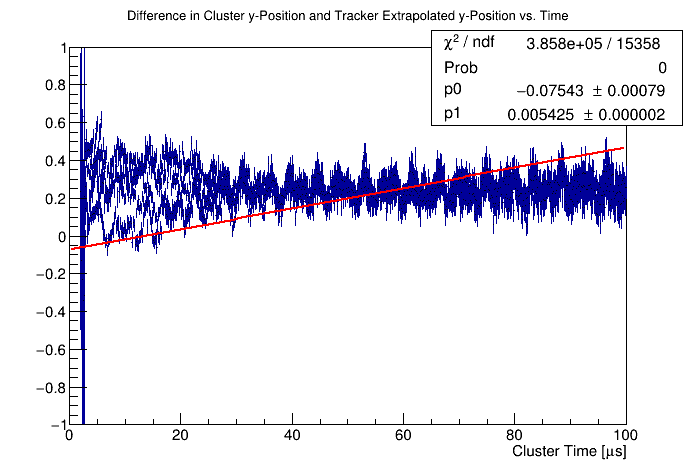

In [133]:
c = r.TCanvas()
h2 = h_yDiff.ProfileX().Clone()
h2.Fit("pol1")
h2.GetYaxis().SetRangeUser(-1,1)
h2.GetXaxis().SetRangeUser(0,100)
h2.Draw()
c.Draw()

In [ ]:
ding = TH1ToNumpyArray(h2)

In [140]:
func = r.TF1("func","pol1",30,200)
fitresult = fitVector(ding[0], ding[1], func, None, ding[2])

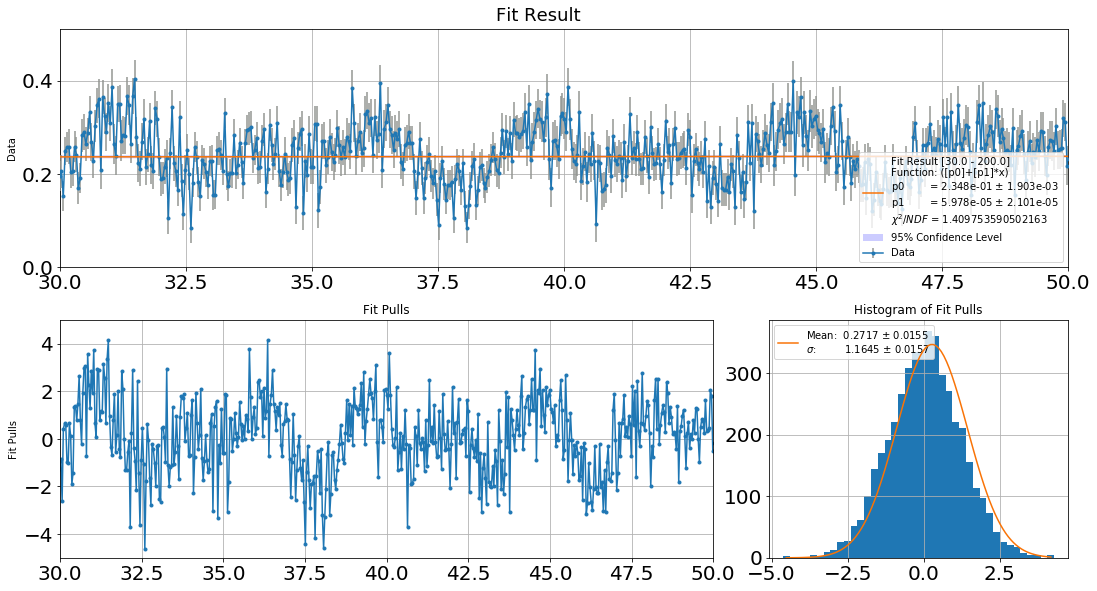

In [157]:
fig,ax = fitresult.draw()
for i in range(0,2):
    ax[i].set_xlim(30,50)
ax[0].set_ylim(0,0.51)
ax[1].set_ylim(-5,5)
plt.show()

Restricting range of FFT to: [25, 200]


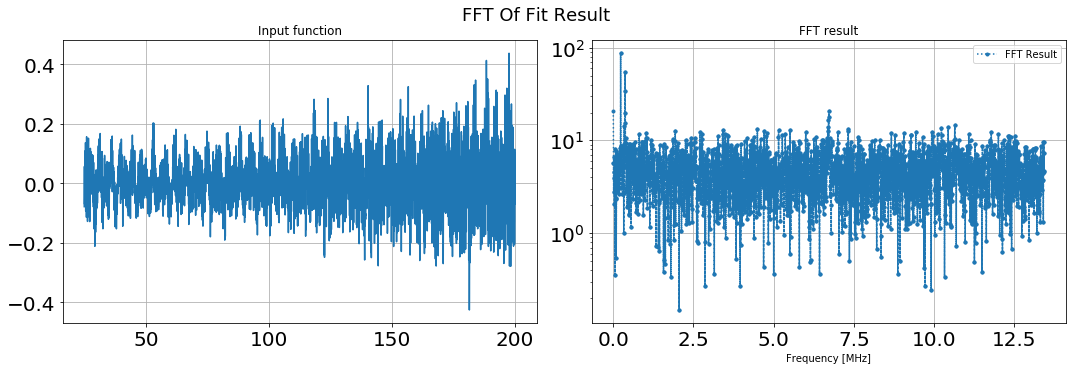

In [158]:
bins, amp = fitresult.fft([25,200],option=1)

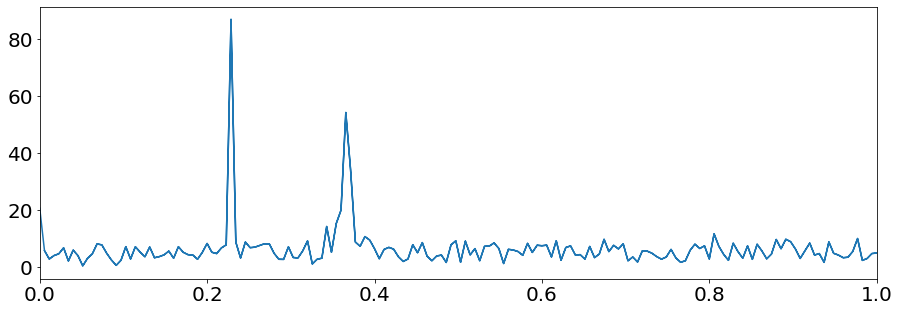

In [159]:
fig,ax = plt.subplots(figsize=(15,5))
plt.plot(np.abs(bins), np.abs(amp))
plt.xlim(0,1)
plt.show()

---

### Now lets load up the endgame clusters by themselves

In [27]:
f = r.TFile("./data/results_endgame_position_may19.root")
f.ls()

TFile**		./data/results_endgame_position_may19.root	
 TFile*		./data/results_endgame_position_may19.root	
  KEY: TDirectoryFile	verticalPosition;1	verticalPosition (CaloHitPositions) folder


In [51]:
#h = f.Get("verticalPosition/clusters"+str(caloToPlot)).Clone()
h = f.Get("verticalPosition/randclusters"+str(caloToPlot)).Clone()
h.SetDirectory(0)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


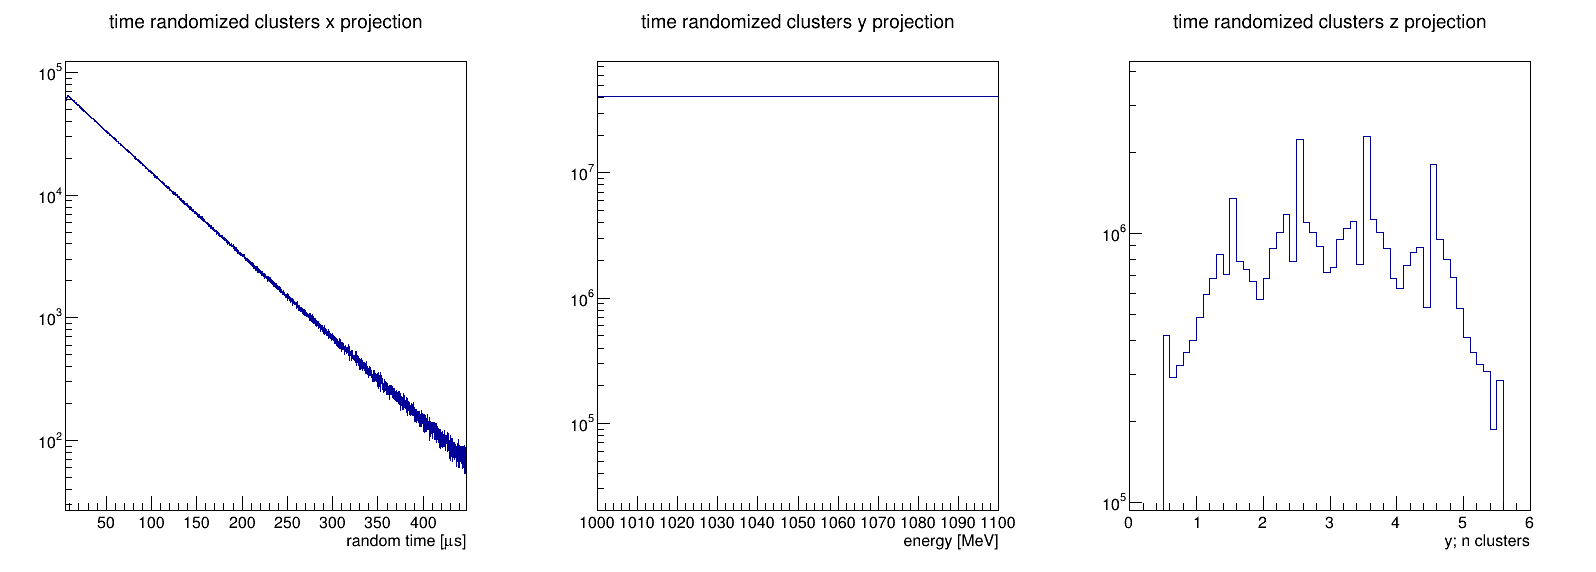

In [65]:
c = r.TCanvas("c","c",1600,600)
c.Divide(3,1)
for i, axi in enumerate(["x","y","z"]):
    c.cd(i+1)
    h.Project3D(axi).Draw()
    r.gPad.SetLogy()
c.Draw()

In [82]:
#set energy range

e1 = 1000
e2 = 2400


h.GetYaxis().SetRange(h.GetYaxis().FindBin(e1),h.GetYaxis().FindBin(e1))
allClusterY_vs_Time = h.Project3D("zx").Clone("allClusterY_vs_Time")

allClusterY_vs_Time.Rebin2D(1,1)
widthDict = getWidths(allClusterY_vs_Time, scale=25, offset=3)

In [96]:
tlow = 10
thigh = 600

func = r.TF1("func","[0] - [1]/(TMath::Exp([2]*x)) + [3]*(x)",tlow,thigh)
func.SetParNames("C", "A", "#tau", "m")
paramVec = [1,10,-0.1,-0.0001,10]

for i,xi in enumerate(paramVec):
    func.SetParameter(i,xi)
#fitresult = fitVector(times, means, func, None, meanErrs)
fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
#fitresult = fitVector(widthDict['times'], widthDict['means'], func, None, widthDict['meanErrs'])

#fitresult = fitVector(times, widths, func, None, widthErrs)
allFitResults.append(fitresult)

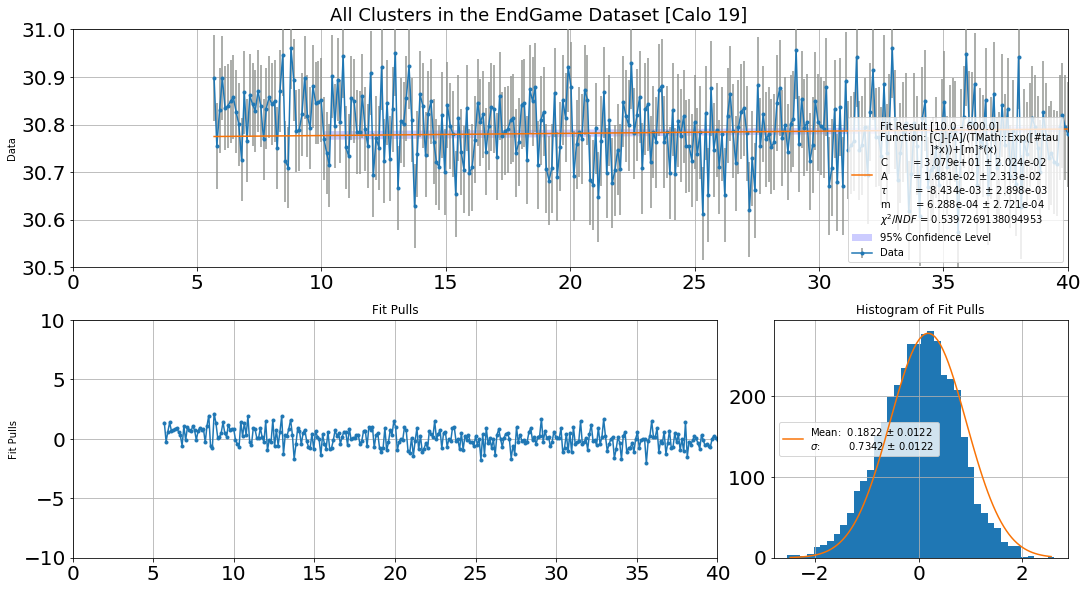

In [97]:
fig,ax = fitresult.draw("All Clusters in the EndGame Dataset [Calo "+str(caloToPlot)+"]",
               yrange=[None, [-10,10]])
for i in range(0,2):
    ax[i].set_xlim(0,40)
ax[0].set_ylim(30.5,31)
plt.show()

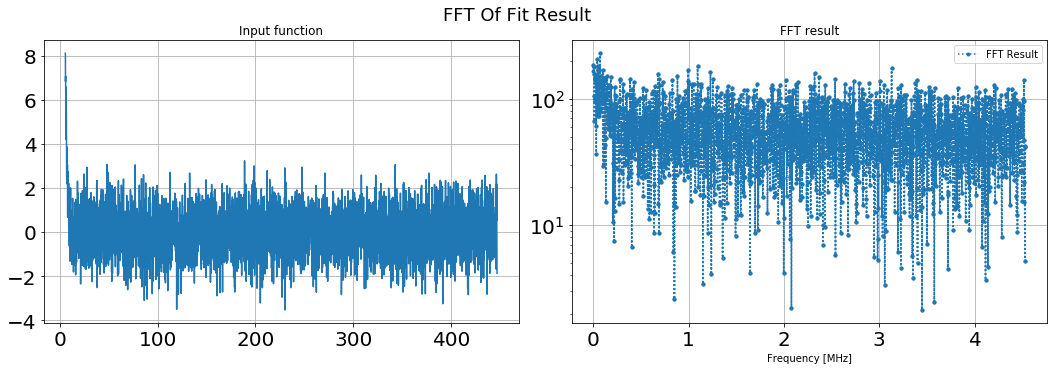

(array([ 0.        ,  0.00226486,  0.00452973, ..., -0.00679459,
        -0.00452973, -0.00226486]),
 array([166.05513117 +0.j        , 166.96697417+79.78113779j,
        179.44080395-14.61392392j, ..., 155.6435796 +21.83836274j,
        179.44080395+14.61392392j, 166.96697417-79.78113779j]))

In [90]:
fitresult.fft(option=2)